# **Visual Searching**
### Object detection : Grounding Dino
### Annotation : Bounding box and mask(SAM)
### Feature Extraction : Clip and DinoV2
### Index Building : FAISS

#### We're gonna be implementing this code two ways

## Grounding Dino:
#### 1- Using Grounding Dino to detect object and extract bounding boxes.
#### 2- Use the Feature extractors to calculate embeddings, embeddings are calculated using two methods
#### - CLIP
####    - DINOV2
#### 3- Buliding an Index using FAISS

## SAM:

In [5]:
HOME = '/home/jupyter/Visual Search'


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!nvidia-smi


Wed Dec 13 05:24:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA L4           On   | 00000000:00:03.0 Off |                    0 |
| N/A   73C    P0    36W /  72W |   4910MiB / 23034MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Grounding DINO and FAISS
Grounding DINO for zero-shot detection
FAISS for index building

In [3]:
import warnings
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ignore all warnings
warnings.filterwarnings("ignore")

HOME = '/home/jupyter/Visual Search'
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .
%cd {HOME}
!pip uninstall -y supervision
!pip install -q supervision==0.6.0
!pip install faiss-gpu

%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'


/home/jupyter/Visual Search
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/home/jupyter/Visual Search/GroundingDINO
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rf-groundingdino 0.1.2 requires supervision>=0.8.0, but you have supervision 0.4.0 which is incompatible.
/home/jupyter/Visual Search
Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rf-groundingdino 0.1.2 requires supervision>=0.8.0, but you have supervision 0.6.0 which is incompatible.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
/home/jupyter/Visual Search

In [147]:
# !pip uninstall -y supervision
# !pip install -q supervision==0.4.0

### Download Grounding DINO weights


In [148]:
import os
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
%cd {HOME}
# Specify the directory path
weights_dir = os.path.join(os.path.expanduser("~/Visual Search"), "weights")

# Create the directory and its parent directories if they don't exist
os.makedirs(weights_dir, exist_ok=True)

%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")


/home/jupyter/Visual Search
/home/jupyter/Visual Search/weights


## Downloading SAM weights

In [149]:
%cd {HOME}
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/home/jupyter/Visual Search
/home/jupyter/Visual Search/weights
/home/jupyter/Visual Search/weights/sam_vit_h_4b8939.pth ; exist: True


# Imports

In [4]:
import sys
import torch
from typing import List
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import math
import requests
import torch
import time
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import base64
from io import BytesIO
import faiss
import cv2
import supervision as sv
import os
HOME = '/home/jupyter/Visual Search'
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


## Load models

### Grounding Dino

In [10]:
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import Model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/home/jupyter/Visual Search/GroundingDINO
final text_encoder_type: bert-base-uncased


### Load SAM

In [5]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Clip Transformer

In [11]:
from transformers import AutoProcessor, AutoTokenizer, CLIPModel
from transformers import CLIPProcessor, CLIPModel

model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")


2023-12-13 05:26:51.607282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 05:26:54.752220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 05:26:54.752319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 05:26:54.975952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 05:26:55.549420: I tensorflow/core/platform/cpu_feature_guar

### DINO V2

In [12]:
from transformers import AutoImageProcessor, Dinov2Model

processor_dino = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model_dino = Dinov2Model.from_pretrained("facebook/dinov2-base")

### Image GPT

In [13]:
from transformers import ImageGPTFeatureExtractor, ImageGPTModel

feature_extractor_gpt = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model_gpt = ImageGPTModel.from_pretrained('openai/imagegpt-small')


In [14]:
%cd {HOME}

/home/jupyter/Visual Search


# Functions

## Object Detection and Cropping (Grounding Dino)

In [15]:

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

def Grounding_Dino(image, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD):
    detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD)
    detections = detections[detections.class_id != None]
    return detections

# def Crop_Object(image, detection):
#     xmin, ymin, xmax, ymax = map(int, detection.xyxy)
#     cropped_image = image[ymin:ymax, xmin:xmax]
#     return cropped_image

def Bounding_Box(image, detections):

    cropped_images = []

    for i in range(len(detections.class_id)):
        xmin = int(detections.xyxy[i][0])
        ymin = int(detections.xyxy[i][1])
        xmax = int(detections.xyxy[i][2])
        ymax = int(detections.xyxy[i][3])

        cropped_image = image[ymin:ymax, xmin:xmax]


        cropped_images.append(cropped_image)

    return cropped_images



## Object Detection and Cropping (SAM)

In [16]:
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

def mask(image, detections):
    
    cropped_masks = []
    for i in range(len(detections.class_id)):
        masks = segment(sam_predictor, image, [detections.xyxy[i]]) 
        binary_mask = (masks[0] > 0.5).astype(np.uint8)  
        cropped_mask = cv2.bitwise_and(image, image, mask=binary_mask)
        cropped_masks.append(cropped_mask)

    return cropped_masks



## Feature Extraction DinoV2

###  DinoV2

In [17]:
def dinoFeatureExtractor(cropped_image):
  query_inputs = processor_dino(images=cropped_image, return_tensors="pt")
  with torch.no_grad():
      query_image_features = model_dino(**query_inputs)
      image_features = query_image_features.last_hidden_state
      image_features = image_features.mean(dim=1)
  return image_features

###  CLIP

In [18]:
def clipFeatureExtractor(cropped_image):
  query_inputs = processor_clip(images=cropped_image, return_tensors="pt")
  query_image_features = model_clip.get_image_features(**query_inputs)
  return query_image_features

###  Image GPT

In [19]:
def gptFeatureExtractor(cropped_image):
  inputs = feature_extractor_gpt(images=cropped_image, return_tensors="pt")
  outputs = model_gpt(**inputs)
  last_hidden_states = outputs.last_hidden_state
  last_hidden_states = last_hidden_states.mean(dim=1)
  return last_hidden_states

### Building FAISS Index

In [15]:
# def FAISS_index(image_features,faiss_index_file):
#     if index is None:
#         index = faiss.IndexFlatL2(image_features.shape[0])
#         print("index was none")

#     index.add(np.expand_dims(image_features, axis=0).astype(np.float32))
    
#     return index

In [20]:
import faiss
import numpy as np

def Feature_extractions(image, indexes):
    index_clip = indexes[0]
    index_dino = indexes[1]
    index_gpt = indexes[2]

    for i, bbox in enumerate(image):

        image_features_clip = clipFeatureExtractor(bbox)
        image_features_clip = image_features_clip.squeeze().detach().numpy()

        if index_clip is None:
            index_clip = faiss.IndexFlatL2(image_features_clip.shape[0])
        
        index_clip.add(np.expand_dims(image_features_clip, axis=0).astype(np.float32))

        image_features_dino = dinoFeatureExtractor(bbox)
        image_features_dino = image_features_dino.squeeze().numpy()
        
        if index_dino is None:
            index_dino = faiss.IndexFlatL2(image_features_dino.shape[0])
            
        index_dino.add(np.expand_dims(image_features_dino, axis=0).astype(np.float32))

        image_features_gpt = gptFeatureExtractor(bbox)
        image_features_gpt = image_features_gpt.squeeze().detach().numpy()
        
        if index_gpt is None:
            index_gpt = faiss.IndexFlatL2(image_features_gpt.shape[0])
            
        index_gpt.add(np.expand_dims(image_features_gpt, axis=0).astype(np.float32))

    return index_clip, index_dino, index_gpt


In [21]:
def dataframe(classes, image_name, detections, image_data_list):
    for i in range(len(detections.class_id)):
        label = f"{classes[detections.class_id[i]]}"
        confidence = f"{detections.confidence[i]:0.2f}"
        image_data = {
            'image name': image_name,  # Adding index to distinguish multiple objects
            'label': label,  # Keep only the label for each iteration
            'confidence': confidence,
        }
        image_data_list.append(image_data)
    return image_data_list


## Feature Extraction and Building FAISS Index - Grounding Dino

In [22]:
def buildIndex(IMAGES_DIRECTORY, CLASSES, IMAGES_EXTENSIONS, BOX_THRESHOLD, TEXT_THRESHOLD,count,df_csv,index_files):
    
    try:
        index_clip_b = faiss.read_index(index_files[0])
        index_dino_b = faiss.read_index(index_files[1])
        index_gpt_b = faiss.read_index(index_files[2])
        index_clip_m = faiss.read_index(index_files[3])
        index_dino_m = faiss.read_index(index_files[4])
        index_gpt_m = faiss.read_index(index_files[5])
        print("if index exists")
        
    except Exception as e:

        index_clip_b = None
        index_dino_b = None
        index_gpt_b = None
        index_clip_m = None
        index_dino_m = None
        index_gpt_m = None
        print("if index does not exist")
    
    indexes_b = [index_clip_b,index_dino_b,index_gpt_b]
    indexes_m = [index_clip_m,index_dino_m,index_gpt_m]
        
    image_data_list = []
    image_paths = sv.list_files_with_extensions(directory=IMAGES_DIRECTORY,extensions=IMAGES_EXTENSIONS)
    if len(image_paths) > count:
        image_paths = image_paths[:count]
        
    for image_path in tqdm(image_paths):
        try:
            image_name = image_path.name
            image_path = str(image_path)
            image = cv2.imread(image_path)

            detections = Grounding_Dino(image, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)
            cropped_bbox = Bounding_Box(image, detections)
            cropped_mask = mask (image, detections)
            image_data_list = dataframe(CLASSES,image_name ,detections , image_data_list )

            indexes_b[0],indexes_b[1],indexes_b[2] = Feature_extractions(cropped_bbox, indexes_b)
            indexes_m[0],indexes_m[1],indexes_m[2]= Feature_extractions(cropped_mask, indexes_m)

        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            continue
    try:
        csv_file = pd.read_csv(df_csv)
        df = pd.concat([csv_file, pd.DataFrame(image_data_list)], ignore_index=True)
        df.to_csv(df_csv, index=False)
        print("if csv exists")

                  
    except Exception as e:
        df = pd.DataFrame(image_data_list)
        df.to_csv(df_csv, index=False)
        print("CSV file does not exist. Created new file.")
        
                  
    try:

        faiss.write_index(indexes_b[0], index_files[0])
        faiss.write_index(indexes_b[1], index_files[1])
        faiss.write_index(indexes_b[2], index_files[2])
        faiss.write_index(indexes_m[0] , index_files[3])
        faiss.write_index(indexes_m[1], index_files[4])
        faiss.write_index(indexes_m[2], index_files[5])

    except Exception as e:
        print(f"Error writing Faiss index: {str(e)}")
        
    

## Query Image Object detection, Selection, Cropping and Feature Extraction - Grounding Dino

## Display Images in Grid

In [23]:
def Choose_Label(image,CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD):
    detections = Grounding_Dino(image, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)
    box_annotator = sv.BoxAnnotator()
    labels = [f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _ in detections]
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))
    object_info = [f"{CLASSES[class_id]} {confidence:0.2f}"
                   for _, _, confidence, class_id, _ in detections]

    print("Object Labels and Confidence Scores:")
    for i, object_label in enumerate(object_info, 1):
        print(f"{i}. {object_label}")

    # Ask the user to choose a label
    if len(object_info) > 1:
        choice = int(input("Choose a label: "))
    else:
        choice = 1

    # Check if the choice is valid
    if 1 <= choice <= len(object_info):
        chosen_object_name, chosen_confidence = object_info[choice - 1].split()
        chosen_object_name = chosen_object_name.strip()
        chosen_confidence = float(chosen_confidence)

        # Find the index of the chosen object
        chosen_index = object_info.index(f'{chosen_object_name} {chosen_confidence:.2f}')
    else:
        print("Invalid choice. Please choose a valid label.")
        
    return chosen_index,detections, chosen_object_name

In [24]:
def DisplayGrid(df, organized_images_path):
    num_columns = 3
    num_images = len(df)
    num_rows = math.ceil(num_images / num_columns)

    # Create a subplot for the grid with adjusted figsize and spacing
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    for i, (_, row) in enumerate(df.iterrows()):
        image_name = row['image name']
        label = row['label']

        # Append label to the path
        label_path = os.path.join(organized_images_path, label)
        image_path = os.path.join(label_path, image_name)

        image = cv2.imread(image_path)

        # Calculate the row and column index for the subplot
        row_index = i // num_columns
        col_index = i % num_columns

        # Display the image in the corresponding subplot
        axs[row_index, col_index].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row_index, col_index].set_title(f"Label: {label}")
        axs[row_index, col_index].axis('off')  # Turn off axis labels for cleaner display

    # Remove empty subplots
    for i in range(len(df), num_rows * num_columns):
        row_index = i // num_columns
        col_index = i % num_columns
        fig.delaxes(axs[row_index, col_index])

    plt.tight_layout()
    plt.show()

In [25]:


def QueryFeatures(SOURCE_IMAGE_PATH,CLASSES,BOX_THRESHOLD,TEXT_THRESHOLD):


    # Load image
    image = cv2.imread(SOURCE_IMAGE_PATH)
    chosen_index,detections,chosen_object_name = Choose_Label(image,CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)
    object_coordinates = {chosen_object_name: detections.xyxy[chosen_index]}

    for object_name, bbox in object_coordinates.items():
        xmin, ymin, xmax, ymax = map(int, bbox)
        cropped_image = image[ymin:ymax, xmin:xmax]
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.show()

    image_features_dino = dinoFeatureExtractor(cropped_image)
    print(image_features_dino.shape)
    image_features_clip = clipFeatureExtractor(cropped_image)
    image_features_gpt = gptFeatureExtractor(cropped_image)

    return image_features_dino , image_features_clip , image_features_gpt

In [26]:
def QueryFeatures_SAM(SOURCE_IMAGE_PATH, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD, sam_predictor):
    image = cv2.imread(SOURCE_IMAGE_PATH)

    chosen_index,detections,chosen_object_name = Choose_Label(image, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)
    # Extract coordinates
    xmin, ymin, xmax, ymax = detections.xyxy[chosen_index]
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

    # Define the bounding box coordinates (xmin, ymin, xmax, ymax)
    bbox = (xmin, ymin, xmax, ymax)

    # Crop the image using the bounding box
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Use SAM for segmentation
    masks = segment(sam_predictor, image, [detections.xyxy[chosen_index]])

    # Crop the segmented mask
    cropped_mask = masks[0]

    # Display the cropped image and cropped segmented mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Cropped Image')

    axes[1].imshow(cropped_mask, cmap='gray')  # Assuming the mask is binary
    axes[1].set_title('Cropped Segmented Mask')

    plt.show()

    # Assuming dinoFeatureExtractor and clipFeatureExtractor are defined somewhere
    image_features_dino = dinoFeatureExtractor(cropped_image)
    image_features_clip = clipFeatureExtractor(cropped_image)
    image_features_gpt = gptFeatureExtractor(cropped_image)


    return image_features_dino, image_features_clip , image_features_gpt

# Function Calling

## Feature Extraction

In [ ]:

Extensions = ['jpg', 'jpeg', 'png']
Box_Threshold = 0.35
Text_Threshold = 0.25
index_files = ['clipIndex_gd.bin','dinoIndex_gd.bin','gptIndex_gd.bin','clipIndex_sam.bin','dinoIndex_sam.bin','gptIndex_sam.bin' ]
labels = ['cabinet','pillow','mattress','table','chair']
columns = ['image name','label','confidence']
df = pd.DataFrame(columns=columns)
count = 99999
df_csv = 'image_indexes.csv'

for obj in labels:
    class_name = [obj]
    Images_Directory = os.path.join('/home/jupyter/data/organized_images/',obj)
    buildIndex(Images_Directory,class_name,Extensions,Box_Threshold,Text_Threshold,count,df_csv,index_files)


if index exists


  0%|          | 0/12013 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [32]:
df = pd.read_csv('image_indexes.csv')

## Reading Index File and Dataframe CSVs

In [27]:
# clip_index_gd = '/home/jupyter/Visual Search/clipIndex_gd.bin'
# dino_index_gd = '/home/jupyter/Visual Search/dinoIndex_gd.bin'
# gpt_index_gd = '/home/jupyter/Visual Search/gptIndex_gd.bin'

index_dino_sam = faiss.read_index('dinoIndex_sam.bin')
index_clip_sam = faiss.read_index('clipIndex_sam.bin')
index_gpt_sam = faiss.read_index('gptIndex_sam.bin')

index_clip_gd = faiss.read_index('clipIndex_gd.bin')
index_dino_gd = faiss.read_index('dinoIndex_gd.bin')
index_gpt_gd = faiss.read_index('gptIndex_gd.bin')

# df = pd.read_csv('/home/jupyter/Visual Search/image_index.csv')
# clip_df_gd = pd.read_csv('/home/jupyter/Visual Search/saved/clipIndex_gd.csv')
# gpt_df_gd = pd.read_csv('/home/jupyter/Visual Search/saved/gptIndex_gd.csv')



In [28]:
index_dino_gd.ntotal

64856

In [34]:
def query(path , k ,index_clip_gd ,index_dino_gd,index_gpt_gd,df):
    CLASSES = ['bed', 'table', 'bench', 'sofa', 'chair','cabinet','pillow','mattress']
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25
    image_features_dino_gd, image_features_clip_gd , image_features_gpt_gd = QueryFeatures(path, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)

    
    query_dino_gd = image_features_dino_gd.squeeze().numpy()
    query_clip_gd = image_features_clip_gd.squeeze().detach().numpy()
    query_gpt_gd = image_features_gpt_gd.squeeze().detach().numpy()



    # Run your GPU code here
    with torch.no_grad():
        distances_dino_gd, indices_dino_gd = index_dino_gd.search(np.expand_dims(query_dino_gd, axis=0).astype(np.float32), k)
        distances_clip_gd, indices_clip_gd = index_clip_gd.search(np.expand_dims(query_clip_gd, axis=0).astype(np.float32), k)
        distances_gpt_gd, indices_gpt_gd = index_gpt_gd.search(np.expand_dims(query_gpt_gd, axis=0).astype(np.float32), k)

    dino_gd = pd.DataFrame({
        'image name': df['image name'].iloc[indices_dino_gd[0]],
        'label' : df['label'].iloc[indices_dino_gd[0]],
        'distance': distances_dino_gd[0]
    })

    clip_gd = pd.DataFrame({
        'image name': df['image name'].iloc[indices_clip_gd[0]],
        'label' : df['label'].iloc[indices_clip_gd[0]],
        'distance': distances_clip_gd[0]
    })

    gpt_gd = pd.DataFrame({
        'image name': df['image name'].iloc[indices_gpt_gd[0]],
        'label' : df['label'].iloc[indices_gpt_gd[0]],
        'distance': distances_gpt_gd[0]
    })

    dino_gd['product_id'] = dino_gd['image name'].str.split('_', n=1).str[0]
    dino_gd = dino_gd.drop_duplicates(subset=['product_id'])
    dino_gd = dino_gd.drop(columns=['product_id'])
    dino_gd = dino_gd[:6]
    clip_gd['product_id'] = clip_gd['image name'].str.split('_', n=1).str[0]
    clip_gd = clip_gd.drop_duplicates(subset=['product_id'])
    clip_gd = clip_gd.drop(columns=['product_id'])
    clip_gd = clip_gd[:6]
    gpt_gd['product_id'] = gpt_gd['image name'].str.split('_', n=1).str[0]
    gpt_gd = gpt_gd.drop_duplicates(subset=['product_id'])
    gpt_gd = gpt_gd.drop(columns=['product_id'])
    gpt_gd = gpt_gd[:6]
    organized_images_path = os.path.join(HOME, '/home/jupyter/data/organized_images/')
    print("DINO Results:")
    DisplayGrid(dino_gd,organized_images_path)
    print("CLIP Results:")
    DisplayGrid(clip_gd,organized_images_path)
    print("ImageGPT Results:")
    DisplayGrid(gpt_gd,organized_images_path)


In [35]:
def query_sam(path , k ,index_clip_sam ,index_dino_sam,index_gpt_sam,df):
    CLASSES = ['bed', 'table', 'bench', 'sofa', 'chair','cabinet','pillow','mattress']
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25
    image_features_dino_sam, image_features_clip_sam , image_features_gpt_sam = QueryFeatures(path, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD)

    
    query_dino_sam = image_features_dino_sam.squeeze().numpy()
    query_clip_sam = image_features_clip_sam.squeeze().detach().numpy()
    query_gpt_sam = image_features_gpt_sam.squeeze().detach().numpy()



    # Run your GPU code here
    with torch.no_grad():
        distances_dino_sam, indices_dino_sam = index_dino_sam.search(np.expand_dims(query_dino_sam, axis=0).astype(np.float32), k)
        distances_clip_sam, indices_clip_sam = index_clip_sam.search(np.expand_dims(query_clip_sam, axis=0).astype(np.float32), k)
        distances_gpt_sam, indices_gpt_sam = index_gpt_sam.search(np.expand_dims(query_gpt_sam, axis=0).astype(np.float32), k)

    dino_sam = pd.DataFrame({
        'image name': df['image name'].iloc[indices_dino_sam[0]],
        'label' : df['label'].iloc[indices_dino_sam[0]],
        'distance': distances_dino_sam[0]
    })

    clip_sam = pd.DataFrame({
        'image name': df['image name'].iloc[indices_clip_sam[0]],
        'label' : df['label'].iloc[indices_clip_sam[0]],
        'distance': distances_clip_sam[0]
    })

    gpt_sam = pd.DataFrame({
        'image name': df['image name'].iloc[indices_gpt_sam[0]],
        'label' : df['label'].iloc[indices_gpt_sam[0]],
        'distance': distances_gpt_sam[0]
    })

    dino_sam['product_id'] = dino_sam['image name'].str.split('_', n=1).str[0]
    dino_sam = dino_sam.drop_duplicates(subset=['product_id'])
    dino_sam = dino_sam.drop(columns=['product_id'])
    dino_sam = dino_sam[:6]
    clip_sam['product_id'] = clip_sam['image name'].str.split('_', n=1).str[0]
    clip_sam = clip_sam.drop_duplicates(subset=['product_id'])
    clip_sam = clip_sam.drop(columns=['product_id'])
    clip_sam = clip_sam[:6]
    gpt_sam['product_id'] = gpt_sam['image name'].str.split('_', n=1).str[0]
    gpt_sam = gpt_sam.drop_duplicates(subset=['product_id'])
    gpt_sam = gpt_sam.drop(columns=['product_id'])
    gpt_sam = gpt_sam[:6]
    organized_images_path = os.path.join(HOME, '/home/jupyter/data/organized_images/')
    print("DINO Results:")
    DisplayGrid(dino_sam,organized_images_path)
    print("CLIP Results:")
    DisplayGrid(clip_sam,organized_images_path)
    print("ImageGPT Results:")
    DisplayGrid(gpt_sam,organized_images_path)


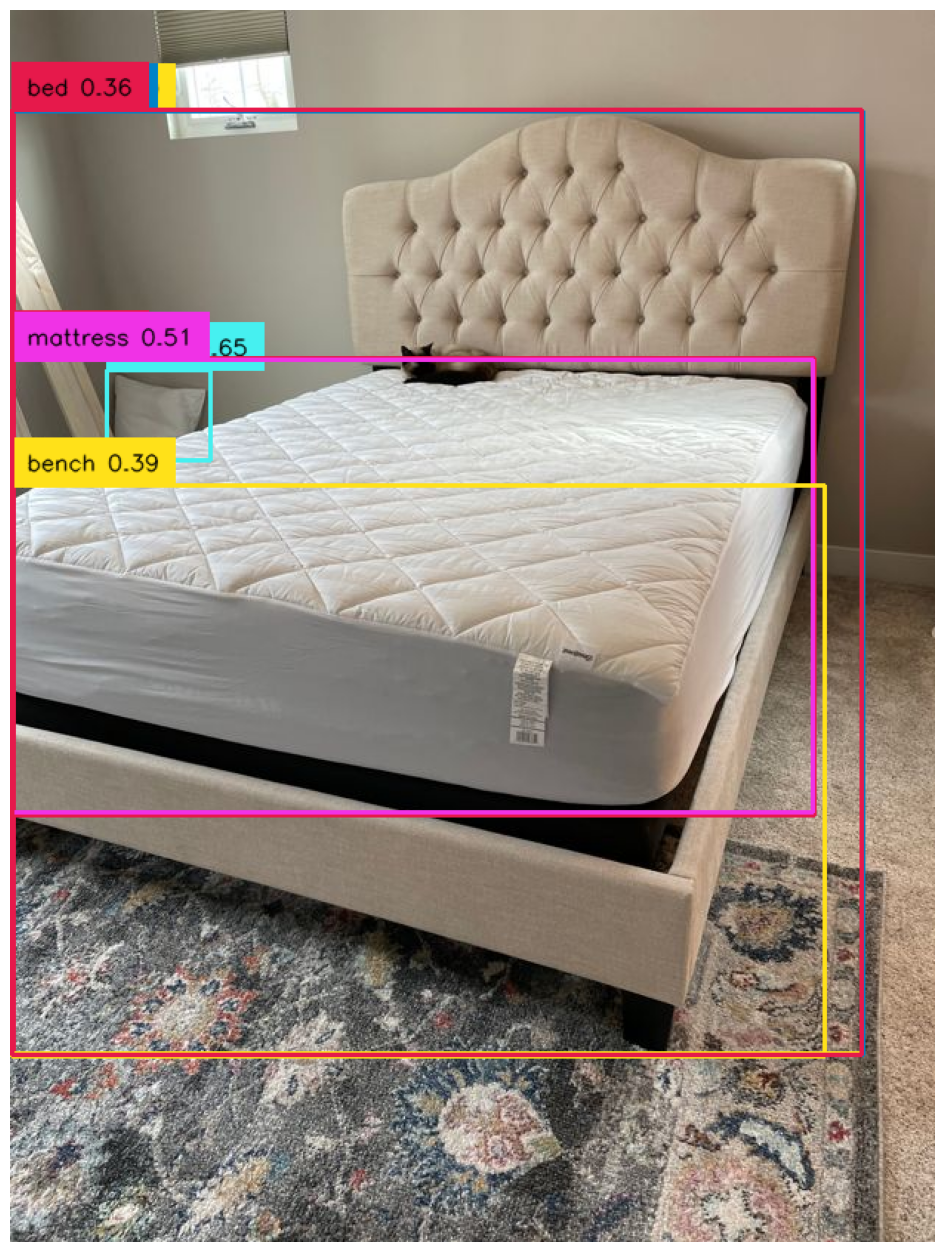

Object Labels and Confidence Scores:
1. pillow 0.65
2. bed 0.48
3. bench 0.40
4. bed 0.38
5. sofa 0.42
6. mattress 0.51
7. bench 0.39
8. bed 0.36


In [ ]:
Test_image = os.path.join(HOME, '/home/jupyter/data/organized_test_images/bed/1219_prod3070085_201cb789-4198-488b-a5eb-4e7df0fb4bee.jpg')
query(Test_image,15,index_clip_gd,index_dino_gd,index_gpt_gd,df)


In [ ]:
query_sam(Test_image,15,index_clip_sam,index_dino_sam,index_gpt_sam,df)
